In [69]:
import pandas as pd
import numpy as np
import pypyodbc
import matplotlib.pyplot as plt
import datetime
import sklearn

## Import Data from SQL

In [70]:
cnxn_DB = pypyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=localhost\SQLEXPRESS;"
                        "Database=Didi_bi;"
                        "Trusted_Connection=yes;")

In [71]:
%%time
rv     = pd.read_sql_query("Select * from [dbo].[restaurants_visitors]" , cnxn_DB)
stores = pd.read_sql_query("Select * from [dbo].[store_info]" , cnxn_DB)
dates  = pd.read_sql_query("Select * from [dbo].[date_info]" , cnxn_DB)

Wall time: 212 ms


In [136]:
rv_df     = rv.copy()
stores_df = stores.copy()
dates_df  = dates.copy()

In [137]:
#adding month and year to calendar data frame.
dates_df['year'] = pd.DatetimeIndex(dates_df['calendar_date']).year
dates_df['month_year'] = pd.to_datetime(dates_df['calendar_date']).dt.to_period('M')
dates_df['month'] = pd.DatetimeIndex(dates_df['calendar_date']).month
dates_df['end_month'] = pd.to_datetime(dates_df['calendar_date']).dt.is_month_end
dates_df.head()

,calendar_date,day_of_week,holiday_flg,year,month_year,month,end_month
0,2016-01-01,Friday,1,2016,2016-01,1,False
1,2016-01-02,Saturday,1,2016,2016-01,1,False
2,2016-01-03,Sunday,1,2016,2016-01,1,False
3,2016-01-04,Monday,0,2016,2016-01,1,False
4,2016-01-05,Tuesday,0,2016,2016-01,1,False


In [138]:
# group visitors by dates and counting unique stores by date

allstores = rv_df.groupby(['visit_date']).agg({'reserve_visitors': 'sum', 'id':'nunique'}).reset_index()

<AxesSubplot:xlabel='visit_date'>

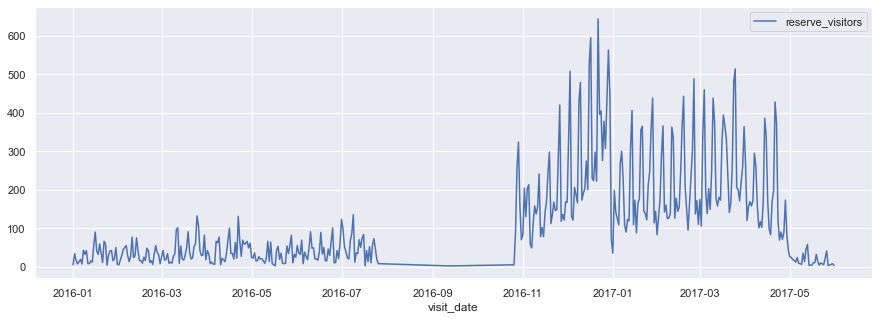

In [139]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})
allstores.plot(x='visit_date', y='reserve_visitors')

In [140]:
data = pd.merge(allstores, dates_df, how='left', left_on=['visit_date'], right_on=['calendar_date'])

In [141]:
data

,visit_date,reserve_visitors,id,calendar_date,day_of_week,holiday_flg,year,month_year,month,end_month
0,2016-01-01,5,1,2016-01-01,Friday,1,2016,2016-01,1,False
1,2016-01-02,34,1,2016-01-02,Saturday,1,2016,2016-01,1,False
2,2016-01-03,17,1,2016-01-03,Sunday,1,2016,2016-01,1,False
3,2016-01-04,7,1,2016-01-04,Monday,0,2016,2016-01,1,False
4,2016-01-06,19,3,2016-01-06,Wednesday,0,2016,2016-01,1,False
...,...,...,...,...,...,...,...,...,...,...
413,2017-05-26,41,3,2017-05-26,Friday,0,2017,2017-05,5,False
414,2017-05-27,3,1,2017-05-27,Saturday,0,2017,2017-05,5,False
415,2017-05-28,4,1,2017-05-28,Sunday,0,2017,2017-05,5,False
416,2017-05-30,8,1,2017-05-30,Tuesday,0,2017,2017-05,5,False


# Forecast 6 mo

(array([135.,  72.,  38.,  32.,  30.,  28.,  16.,  11.,   7.,   8.,   8.,
         11.,   4.,   8.,   3.,   3.,   1.,   1.,   1.,   1.]),
 array([  2. ,  34.1,  66.2,  98.3, 130.4, 162.5, 194.6, 226.7, 258.8,
        290.9, 323. , 355.1, 387.2, 419.3, 451.4, 483.5, 515.6, 547.7,
        579.8, 611.9, 644. ]),
 <BarContainer object of 20 artists>)

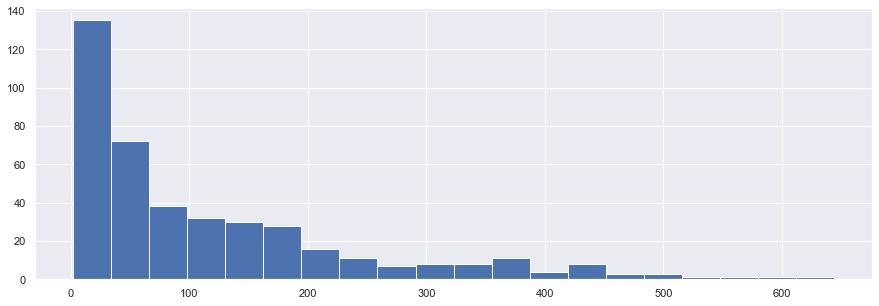

In [142]:
#visitors distribution
plt.hist(data.reserve_visitors, bins=20)

In [143]:
data['log_visits'] = np.log(data['reserve_visitors'])

(array([ 3.,  0.,  2.,  6.,  5.,  4.,  3., 18.,  9., 10., 11., 20., 13.,
        14., 23., 23., 17., 20., 21., 19., 17., 28., 26., 27., 18., 16.,
        12., 20., 10.,  3.]),
 array([0.69314718, 0.88563223, 1.07811728, 1.27060234, 1.46308739,
        1.65557244, 1.84805749, 2.04054254, 2.23302759, 2.42551264,
        2.6179977 , 2.81048275, 3.0029678 , 3.19545285, 3.3879379 ,
        3.58042295, 3.772908  , 3.96539306, 4.15787811, 4.35036316,
        4.54284821, 4.73533326, 4.92781831, 5.12030337, 5.31278842,
        5.50527347, 5.69775852, 5.89024357, 6.08272862, 6.27521367,
        6.46769873]),
 <BarContainer object of 30 artists>)

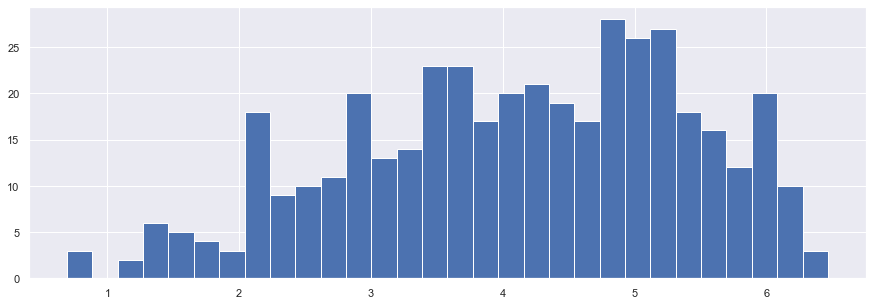

In [144]:
#log visitors distribution
plt.hist(data.log_visits, bins=30)

In [145]:
np.mean(data.log_visits)

4.118037372557549

In [146]:
# get dummies

data_filtered_dummy = pd.get_dummies(data, columns=['day_of_week', 'end_month']) 

In [147]:
data_filtered_dummy

,visit_date,reserve_visitors,id,calendar_date,holiday_flg,year,month_year,month,log_visits,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,end_month_False,end_month_True
0,2016-01-01,5,1,2016-01-01,1,2016,2016-01,1,1.609438,1,0,0,0,0,0,0,1,0
1,2016-01-02,34,1,2016-01-02,1,2016,2016-01,1,3.526361,0,0,1,0,0,0,0,1,0
2,2016-01-03,17,1,2016-01-03,1,2016,2016-01,1,2.833213,0,0,0,1,0,0,0,1,0
3,2016-01-04,7,1,2016-01-04,0,2016,2016-01,1,1.945910,0,1,0,0,0,0,0,1,0
4,2016-01-06,19,3,2016-01-06,0,2016,2016-01,1,2.944439,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2017-05-26,41,3,2017-05-26,0,2017,2017-05,5,3.713572,1,0,0,0,0,0,0,1,0
414,2017-05-27,3,1,2017-05-27,0,2017,2017-05,5,1.098612,0,0,1,0,0,0,0,1,0
415,2017-05-28,4,1,2017-05-28,0,2017,2017-05,5,1.386294,0,0,0,1,0,0,0,1,0
416,2017-05-30,8,1,2017-05-30,0,2017,2017-05,5,2.079442,0,0,0,0,0,1,0,1,0


In [148]:
# define X set

feature_cols = ['id', 'holiday_flg', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'month', 'year', 'end_month_True']
X = data_filtered_dummy[feature_cols]

In [149]:
# define y set = log visits

y = data_filtered_dummy['log_visits'].values

In [150]:
from sklearn.model_selection import train_test_split

In [151]:
# split data set

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

# LinearRegression

In [152]:
from sklearn.linear_model  import LinearRegression


model = LinearRegression()


model_fit = model.fit(X_train , y_train)

print(model.score(X_train , y_train))

0.7778043255295659


In [153]:
y_pred = model_fit.predict(X_test)

In [154]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [155]:
y_test_final = np.exp(y_test)
y_pred_final = np.exp(y_pred)

In [156]:
from sklearn import metrics
print(metrics.mean_absolute_error(y_test_final, y_pred_final))
print(np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_final)))
print(mean_absolute_percentage_error(y_test_final, y_pred_final))

56.34936641385666
106.76355733463308
44.31179647120212


# random forest

In [157]:
from sklearn.ensemble import RandomForestRegressor
# fit model
model_randomforest = RandomForestRegressor(n_estimators=1000)
model_fit_randomforest = model_randomforest.fit(X_train , y_train)

In [158]:
y_pred_randomforest = model_fit_randomforest.predict(X_test)

In [159]:
y_test_final = np.exp(y_test)
y_pred_randomforest_final = np.exp(y_pred_randomforest)

In [160]:
print(metrics.mean_absolute_error(y_test_final, y_pred_randomforest_final))
print(np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_randomforest_final)))
print(np.sqrt(metrics.mean_squared_log_error(y_test_final, y_pred_randomforest_final)))
print(mean_absolute_percentage_error(y_test_final, y_pred_randomforest_final))

29.920438613127686
48.45043315787044
0.477143380357511
33.9397577862634


In [161]:
model_fit_randomforest.feature_importances_

array([0.86560719, 0.00889374, 0.01051887, 0.0071443 , 0.00813322,
       0.00917526, 0.01471821, 0.00909027, 0.04636116, 0.01719492,
       0.00316287])

<BarContainer object of 11 artists>

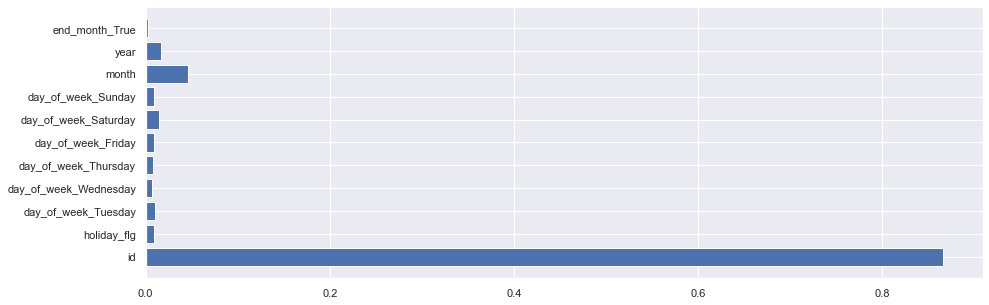

In [162]:
plt.barh(X.columns, model_fit_randomforest.feature_importances_)

In [163]:
from sklearn.model_selection import GridSearchCV

In [164]:
param_grid = {
    'n_estimators': [1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [165]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [1000]}, verbose=2)

In [166]:
print(grid_search.best_params_)

{'n_estimators': 1000}


In [167]:
grid_search_rf = grid_search.predict(X_test)

In [168]:
y_test_final2= np.exp(y_test)
y_pred_randomforest_final2 = np.exp(grid_search_rf)

In [169]:
print(metrics.mean_absolute_error(y_test_final2, y_pred_randomforest_final2))
print(np.sqrt(metrics.mean_squared_error(y_test_final2, y_pred_randomforest_final2)))
print(np.sqrt(metrics.mean_squared_log_error(y_test_final2, y_pred_randomforest_final2)))
print(mean_absolute_percentage_error(y_test_final2, y_pred_randomforest_final2))

29.5744441212346
48.222613131493425
0.47602087750628547
33.83959910438647


# XGBoost

In [170]:
import xgboost as xgb

In [171]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

In [172]:
xg_reg.fit(X_train,y_train)

preds_xgb = xg_reg.predict(X_test)

In [173]:
y_test_final = np.exp(y_test)
y_pred_xgb_final = np.exp(preds_xgb)

In [174]:
# grid search results

print(metrics.mean_absolute_error(y_test_final, y_pred_xgb_final))
print(np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_xgb_final)))
print(np.sqrt(metrics.mean_squared_log_error(y_test_final, y_pred_xgb_final)))
print(mean_absolute_percentage_error(y_test_final, y_pred_xgb_final))

35.91333744071779
57.784934359243756
0.5661248582943709
42.86373040004647


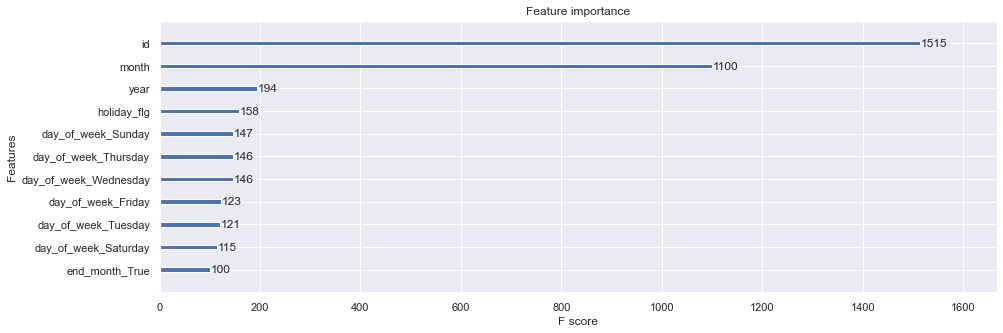

In [175]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Distinct count of stores is the feature with more importance 

# Gradient Boosting 

In [176]:
from sklearn.ensemble import GradientBoostingRegressor

In [177]:
model_gbr = GradientBoostingRegressor()

In [178]:
fit_model_gbr = model_gbr.fit(X_train, y_train)
pred_gbr = model_gbr.predict(X_test)

In [179]:
y_test_final = np.exp(y_test)
y_pred_gb_final = np.exp(pred_gbr)

In [180]:
print(metrics.mean_absolute_error(y_test_final, y_pred_gb_final))
print(np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_gb_final)))
print(np.sqrt(metrics.mean_squared_log_error(y_test_final, y_pred_gb_final)))
print(mean_absolute_percentage_error(y_test_final, y_pred_gb_final))

29.675500657314668
46.14159465287599
0.45155322788036784
32.170037003933224


In [181]:
params = {'n_estimators': [100],
          'learning_rate':[0.1],
          'max_depth': [5,6],
          'min_samples_split': [1,2,3]}

model_gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator = model_gbr, param_grid = params, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [182]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\danie\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.8306574  0.82491917        nan 0.8109974  0.81817295]
  warnings.warn(


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [5, 6],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100]},
             verbose=2)

In [183]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [184]:
grid_search_gb = grid_search.predict(X_test)

In [185]:
y_test_final_gb2= np.exp(y_test)
y_pred_final_gb2 = np.exp(grid_search_gb)

In [186]:
# grid search results

print(metrics.mean_absolute_error(y_test_final_gb2, y_pred_final_gb2))
print(np.sqrt(metrics.mean_squared_error(y_test_final_gb2, y_pred_final_gb2)))
print(np.sqrt(metrics.mean_squared_log_error(y_test_final_gb2, y_pred_final_gb2)))
print(mean_absolute_percentage_error(y_test_final_gb2, y_pred_final_gb2))

31.326464372931802
48.92099957390067
0.48778863535149675
36.26181559093873


# fit final model (GB) in whole dataset

In [187]:
model_gbr.fit(X,y)

GradientBoostingRegressor()

# predicting next 6 months

In [188]:
future = pd.read_excel("future_dataset.xlsx", parse_dates=[0])

In [189]:
future.fillna(0, inplace=True)

In [190]:
future['year'] = pd.DatetimeIndex(future['calendar_date']).year
future['month_year'] = pd.to_datetime(future['calendar_date']).dt.to_period('M')
future['month'] = pd.DatetimeIndex(future['calendar_date']).month
future['end_month'] = pd.to_datetime(future['calendar_date']).dt.is_month_end
future.head()

,calendar_date,day_of_week,holiday_flg,id,year,month_year,month,end_month
0,2017-06-01,Thursday,0.0,16,2017,2017-06,6,False
1,2017-06-02,Friday,0.0,19,2017,2017-06,6,False
2,2017-06-03,Saturday,0.0,19,2017,2017-06,6,False
3,2017-06-04,Sunday,0.0,13,2017,2017-06,6,False
4,2017-06-05,Monday,0.0,13,2017,2017-06,6,False


In [191]:
future_dummy = pd.get_dummies(future, columns=['day_of_week', 'end_month']) 

In [192]:
feature_cols_future = ['id','holiday_flg', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'month', 'year', 'end_month_True']
X_future = future_dummy[feature_cols_future]

In [201]:
X_future.head()

,id,holiday_flg,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday,day_of_week_Sunday,month,year,end_month_True
0,16,0.0,0,0,1,0,0,0,6,2017,0
1,19,0.0,0,0,0,1,0,0,6,2017,0
2,19,0.0,0,0,0,0,1,0,6,2017,0
3,13,0.0,0,0,0,0,0,1,6,2017,0
4,13,0.0,0,0,0,0,0,0,6,2017,0


In [194]:
pred_gbr_future = model_gbr.predict(X_future)

In [195]:
final_6mo = np.exp(pred_gbr_future)

In [196]:
final_6mo_df = pd.DataFrame({'Visitors': final_6mo[:]})

In [197]:
merge_final_df= final_6mo_df.join(future)

In [198]:
merge_final_df= merge_final_df.round({'Visitors': 0})

In [202]:
merge_final_df.Visitors.sum()

25948.0

In [199]:
merge_final_df.to_excel("6moprediction_v3.xlsx")